<a href="https://colab.research.google.com/github/Hira-Nav/DataScienceProjects/blob/main/Leveraging_AI_(DRL)_to_play_Breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DRL - DQN Breakout v0
Deep Reinforcement Learning - Deep-Q Network
Leveraging AI to learn how to play Breakout to maximise points

In [ ]:
#Install Packages

#from google.colab import drive
#drive.mount('/content/gdrive')
#!pip install torch
#!pip install -U "ray[rllib]" torch

#!pip install atari-py
#!pip install gym[atari]

## 1. Define Wrapper to use Breakout v0 with RLLib.

- Environment wrapper:
https://github.com/mgbellemare/Arcade-Learning-Environment
- Gym spaces:
https://gym.openai.com/docs/




In [ ]:
# Import Libraries
import gym
import random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
# List games
import atari_py
print(atari_py.list_games())

['adventure', 'air_raid', 'alien', 'amidar', 'assault', 'asterix', 'asteroids', 'atlantis', 'bank_heist', 'battle_zone', 'beam_rider', 'berzerk', 'bowling', 'boxing', 'breakout', 'carnival', 'centipede', 'chopper_command', 'crazy_climber', 'defender', 'demon_attack', 'double_dunk', 'elevator_action', 'enduro', 'fishing_derby', 'freeway', 'frostbite', 'gopher', 'gravitar', 'hero', 'ice_hockey', 'jamesbond', 'journey_escape', 'kaboom', 'kangaroo', 'krull', 'kung_fu_master', 'montezuma_revenge', 'ms_pacman', 'name_this_game', 'phoenix', 'pitfall', 'pong', 'pooyan', 'private_eye', 'qbert', 'riverraid', 'road_runner', 'robotank', 'seaquest', 'skiing', 'solaris', 'space_invaders', 'star_gunner', 'tennis', 'time_pilot', 'tutankham', 'up_n_down', 'venture', 'video_pinball', 'wizard_of_wor', 'yars_revenge', 'zaxxon']


In [ ]:
#Explore Environment
env = gym.make('Breakout-v0')
obs = env.reset()
#env.render()
print('Number of actions: \n', env.action_space)
print('State shape, type: \n', env.observation_space.shape)
print(env.unwrapped.get_action_meanings())

Number of actions: 
 Discrete(4)
State shape, type: 
 (210, 160, 3)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


### 2. Define and train Basic DQN algorithm.

You can take inspiration from:
https://docs.ray.io/en/latest/rllib/rllib-training.html#basic-python-api

Experiment with the different parameters of the configuration:
https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#deep-q-networks-dqn-rainbow-parametric-dqn





In [ ]:
#Import more libraries

from gym.spaces import Discrete, Box
import ray
from ray import tune
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from gym.spaces import Discrete, Box

In [ ]:
#Configure setting for DQN Basic

config = dqn.DEFAULT_CONFIG.copy()
config["env"] = 'Breakout-v0'
config["framework"] = "torch"
config["dueling"] = False
config["double_q"] = False
config["num_workers"] = 2
config["model"] = {"fcnet_hiddens":[64,64],
                   "fcnet_activation":"relu"}
dqn_basic = dqn.DQNTrainer(config=config)

SyntaxError: invalid syntax (<ipython-input-5-0b55a3d6232a>, line 8)

### 3. Hyperparameter tuning using Ray Tune

In [ ]:
### 1. Tuning - Evaluation and objective function

In [ ]:
import ray
from ray import tune
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print


def evaluation_fn(result):
    return result['episode_reward_mean']

def objective_fn(config):

    trainer = dqn.DQNTrainer(config=config)

    for i in range(200):
        # Perform one iteration of training the policy with DQN
        result = trainer.train()
        intermediate_score = evaluation_fn(result)

         # Feed the score back back to Tune.
        tune.report(iterations=i, mean_reward=intermediate_score)


In [ ]:
## 2. Optimization loop
config = dqn.DEFAULT_CONFIG.copy()
config["dueling"] = tune.grid_search([True, False])
config["double_q"] = tune.grid_search([True, False])
config["env"] = 'Breakout-v0'
config["model"] = { "fcnet_hiddens": ([[128, 128], [64, 64]]),
                    "fcnet_activation": {'relu','tanh'}
config["gamma"] = tune.grid_search([0.9,0.99])
config["lr"] = tune.grid_search([0.0001,0.00001])
config["initial_epsilon"] = tune.grid_search([0.99,1])
config["num_workers"] = 2
#config["evaluation_duration"] = 200

In [ ]:
analysis = tune.run(
        objective_fn,
        metric="mean_reward",

        stop={"training_iteration": 10},
        mode="max",
        num_samples=3,
        config=config)


print("Best hyperparameters found were: ", analysis.get_best_config(metric="score", mode="max"))

In [ ]:
## 3 Analyse Best params results on

df = analysis.dataframe(metric="mean_reward", mode="max")
df[['config/gamma', 'config/double_q', 'config/dueling', 'mean_reward']]

NameError: name 'analysis' is not defined

### 4. Comparative Anlaysis on differnet DQN models

In [ ]:
#Configure setting for Double DQN (DDQN)
config = dqn.DEFAULT_CONFIG.copy()
config["env"] = 'Breakout-v0'
config["framework"] = "torch"
config["dueling"] = False
config["double_q"] = True
config["num_workers"] = 2
config["model"] = {"fcnet_hiddens":[64,64],
                   "fcnet_activation":"relu"}

ddqn = dqn.DQNTrainer(config=config)

2022-04-24 09:54:09,116	WARNING util.py:55 -- Install gputil for GPU system monitoring.


In [ ]:
#Configure setting for Deuling DQN (DDQN)
config = dqn.DEFAULT_CONFIG.copy()
config["env"] = 'Breakout-v0'
config["framework"] = "torch"
config["dueling"] = True
config["double_q"] = False
config["num_workers"] = 2
config["model"] = {"fcnet_hiddens":[128,128],
                   "fcnet_activation":"relu"}

dueldqn = dqn.DQNTrainer(config=config)

2022-04-24 11:30:27,145	WARNING util.py:55 -- Install gputil for GPU system monitoring.


In [ ]:
#Configure setting for Deuling DDQN (DDDQN)

config = dqn.DEFAULT_CONFIG.copy()
config["env"] = 'Breakout-v0'
config["framework"] = "torch"
config["dueling"] = True
config["double_q"] = True
config["num_workers"] = 1
config["model"] = {"fcnet_hiddens":[64,64],
                   "fcnet_activation":"relu"}
dddqn = dqn.DQNTrainer(config=config)

2022-04-24 10:17:20,617	INFO trainable.py:127 -- Trainable.setup took 11.041 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-04-24 10:17:20,619	WARNING util.py:55 -- Install gputil for GPU system monitoring.


In [ ]:
#Configure setting for Best Param's DQN ()
config = dqn.DEFAULT_CONFIG.copy()
config["dueling"] = True
config["double_q"] = True
config["env"] = 'Breakout-v0'
config["model"] = { "fcnet_hiddens": [128, 128],
                    "fcnet_activation": 'relu',}
config["gamma"] = 0.99
config["lr"] = 0.00001
config["num_workers"] = 2

dqn_best = dqn.DQNTrainer(config=config)

2022-04-24 11:13:52,153	INFO trainable.py:127 -- Trainable.setup took 12.090 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-04-24 11:13:52,155	WARNING util.py:55 -- Install gputil for GPU system monitoring.


### 5. Train remainder RL model types and compare

In [ ]:
import pandas as pd
#train_models = {'model_name':['dqn_basic','ddqn','dueldqn','dddqn','dqn_best'],
#                'type':[dqn_basic,ddqn,dueldqn,dddqn,dqn_best]}
train_models = {'model_name':['dueldqn'],
                'type':[dueldqn]}
df = pd.DataFrame(train_models)
#define lists
data_list = []
episodes=101

#Define dataframe for plots
data = pd.DataFrame(columns = ['model','episode','avg_rewards'])

# Can optionally call trainer.restore(path) to load a checkpoint.
for index, row in df.iterrows():
    model_name = row["model_name"]

    for x in range(episodes):
        # Perform one iteration of training the policy with DQN
        result = row["type"].train()
        avg_rewards = result['episode_reward_mean']

        if x % 10 == 0:
#            checkpoint = 'checkpoint'.save()
            print("checkpoint saved at ",x," episodes",avg_rewards)

        data_list = [model_name,x,avg_rewards]  #Rolling average lst 7 episodes (week6 labs)
        temporary_df = pd.DataFrame([data_list], columns=['model','episode','avg_rewards'])
        data = data.append(temporary_df, ignore_index=True)

data.to_csv('data_5.csv')

checkpoint saved at  0  episodes 0.5
checkpoint saved at  10  episodes 1.3191489361702127
checkpoint saved at  20  episodes 1.4505494505494505
checkpoint saved at  30  episodes 1.74
checkpoint saved at  40  episodes 1.91
checkpoint saved at  50  episodes 1.9
checkpoint saved at  60  episodes 2.17
checkpoint saved at  70  episodes 2.54
checkpoint saved at  80  episodes 2.88
checkpoint saved at  90  episodes 3.16
checkpoint saved at  100  episodes 3.63


In [ ]:
import pandas as pd
df1 = pd.read_csv('data_1.csv')
df1["model"].replace({"dqn_basic": "dqn_best"}, inplace=True)
df2 = pd.read_csv('data_2.csv')
df3 = pd.read_csv('data_3.csv')
df4 = pd.read_csv('data_4.csv')
df4["model"].replace({"dqn_best": "dqn_basic"}, inplace=True)
df_main = pd.read_csv('data_5.csv')

df2 = df2.append(df1)
df3 = df3.append(df2)
df4 = df4.append(df3)
df_main = df_main.append(df4)


df_main['avg_rewards'] = df_main['avg_rewards'].astype(float)
df_main['episode'] = df_main['episode'].astype(float)
df_main

,Unnamed: 0,model,episode,avg_rewards
0,0,dueldqn,0.0,0.500000
1,1,dueldqn,1.0,0.875000
2,2,dueldqn,2.0,1.454545
3,3,dueldqn,3.0,1.400000
4,4,dueldqn,4.0,1.550000
...,...,...,...,...
96,96,dqn_best,96.0,6.320000
97,97,dqn_best,97.0,6.400000
98,98,dqn_best,98.0,6.440000
99,99,dqn_best,99.0,6.520000


[Text(0.5, 1.0, 'DQN Performances - Average Rewards vs Episodes')]

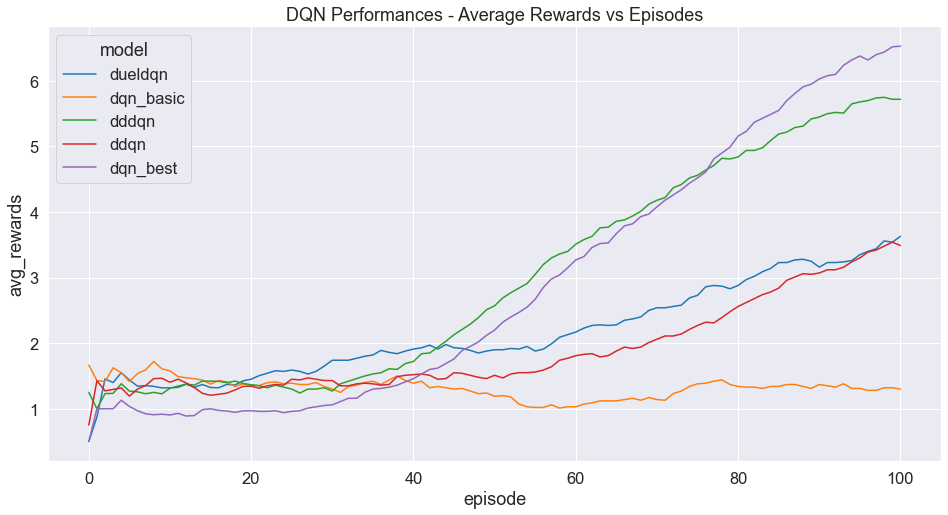

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.set(font_scale=2)
sns.lineplot(data=df_main, x="episode", y ="avg_rewards", hue = 'model',ci=None,
             palette = "tab10").set(title='DQN Performances - Average Rewards vs Episodes')